## Phasing single diffraction pattern

We are trying the single assembled diffraction pattern from Fig. 10

In [1]:
# Use autoreload
%load_ext autoreload
%autoreload 2

# Import modules
import sys, h5py
import numpy as np
import scipy.ndimage as ndimage
import spimage
%matplotlib inline

# Import modules from src directory
sys.path.append("../src")
import plotting

In [2]:
# Configuration (Experiment)
distance_back  = 2.4 #[m]
distance_front = 0.497 #[m]
pixelsize = 110e-6 #[m]
wavelength = 0.2262e-9 #[m]

### 1. Loading data from file

In [3]:
# Loading the signal (assembled)
filename_signal = "../analysis/signal/signal_assembled.h5"
with h5py.File(filename_signal, 'r') as f:
    signal_data = np.rot90(f['data/data'][:], k=2)
    signal_mask = ~np.rot90(f['data/mask'][:].astype(np.bool), k=2)  
    signal_diameter = f['diameter'][...]
    signal_intensity = f['intensity'][...]
    signal_id = f['id'][...]

### 2. Pre-processing (downsampling, cropping)

In [4]:
# Downsampling
downsampling = 4
intensities, mask = spimage.downsample(signal_data, downsampling, mask=signal_mask, mode='integrate')

In [59]:
# Cropping
cropping = 154
cx, cy = -2,-6
intensities_cropped = intensities[cropping+cy:-cropping+cy-1,cropping+cx:-cropping+cx-1]
mask_cropped = mask[cropping+cy:-cropping+cy-1,cropping+cx:-cropping+cx-1]
sh = intensities_cropped.shape
print "Shape after downsampling and cropping: ", sh

Shape after downsampling and cropping:  (128, 128)


In [60]:
# Check if the center
x,y = spimage.find_center(intensities_cropped,mask_cropped,method='blurred', 
                          x0=sh[1]/2, y0=sh[0]/2,dmax=4, 
                          threshold=0.5, blur_radius=2)
print "Step 1: Found center position (%.2f, %2.f)" %(x,y)

Step 1: Found center position (0.50,  0)


In [61]:
# Pixelsize in real space
dx = wavelength * distance_front / (intensities_cropped.shape[0] * pixelsize*downsampling) #[m/px]
print "One pixel in real space corresponds to %.1f nm" %(dx*1e9)
print "The support should have a size (diameter) of about %.2f px" %(signal_diameter / (dx*1e9))

One pixel in real space corresponds to 2.0 nm
The support should have a size (diameter) of about 21.66 px


In [62]:
# Convert index to q (in nm)
x_to_q = lambda x, d: (2*np.sin(np.arctan2(x*pixelsize*downsampling, d)/2.)) / wavelength / 1e9

### 3. Plotting the diffraction intensities (input)

In [63]:
img = np.copy(intensities_cropped)
img[img<=0] = 1e-5
plot = plotting.Plot(fontsize=8, colorbar=True, axes_visible=False, save_png=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.colorbar_label = r'Intensity [photons/pixel]'
plot.plotting_a_map(0, img, log=True, mask=mask_cropped, bad='0.8', under='w', vmax=100, cmap='BuPu')
plot.save('../plots/phasing_input.png')
plot.show()

### 4. Phasing using RAAR

In [306]:
niter_raar = 0
niter_hio  = 50000
niter_er   = 10000
niter_total = niter_raar + niter_hio + niter_er
beta = 0.9
support_size = 24.

In [307]:
R = spimage.Reconstructor()
R.set_intensities(intensities_cropped)
R.set_mask(mask_cropped)
R.set_number_of_iterations(niter_total)
R.set_number_of_outputs_images(5)
R.set_number_of_outputs_scores(200)
R.set_initial_support(radius=support_size/2)
R.set_support_algorithm("static", number_of_iterations=niter_total)
R.append_phasing_algorithm("raar",beta_init=beta, beta_final=beta, number_of_iterations=niter_raar)
R.append_phasing_algorithm("hio",beta_init=beta, beta_final=beta, number_of_iterations=niter_hio)
R.append_phasing_algorithm("er", number_of_iterations=niter_er)
#output = R.reconstruct()
output = R.reconstruct_loop(25)

In [308]:
# Collect results
recons  = output['real_space_final']
fourier = output['fourier_space_final']
support = output['support_final']
rerror = output["scores_final"]["real_error"]
ferror = output["scores_final"]["fourier_error"]

In [309]:
# Calculate PRTF
output_prtf = spimage.prtf(recons, support, enantio=True, translate=True)

In [310]:
# Collect PRTF results
superimage = output_prtf['super_image']
prtf_2d    = output_prtf['prtf']

### 5. Plotting the phasing results

In [311]:
plot = plotting.Plot(fontsize=8, cols=2, colorbar=True, axes_visible=False, save_png=True)
plot.title_label = ['Measured intensities', 'After phasing']
plot.xlabel = 2*['']
plot.ylabel = 2*['']
plot.colorbar_label = r'Intensity [photons/pixel]'
plot.plotting_a_map(0, img, 
                    log=True, mask=mask_cropped, bad='0.8', under='w', vmin=1e-2, vmax=100, cmap='BuPu')
plot.plotting_a_map(1, np.abs(fourier[-1])**2, 
                    log=True, mask=None, bad='0.8', under='w', vmin=1e-5, vmax=100, cmap='BuPu')
plot.save('../plots/phasing_fourier.png')
plot.show()

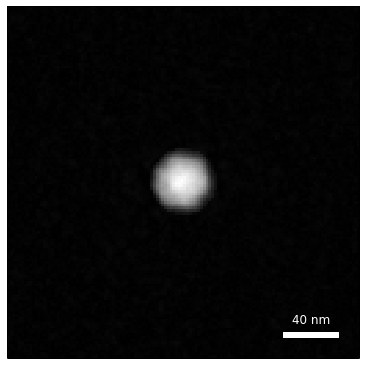

In [312]:
plot = plotting.Plot(fontsize=8, axes_visible=False, save_png=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.plotting_a_map(0, np.abs(recons[-1]), cmap='gray')
plot.plotting_a_rectangle(0, 100, 118, 40./(1e9*dx), 2, facecolor='w', edgecolor='w')
plot.axes[0].text(100+20./(1e9*dx), 116, '40 nm', ha='center', va='bottom', fontsize=12, color='w')
#plot.save('../plots/phasing_recons.png')
plot.show()

In [313]:
plot = plotting.Plot(fontsize=8, rows=5, cols=5, axes_visible=False, save_png=True)
plot.title_label = 25*['']
plot.xlabel = 25*['']
plot.ylabel = 25*['']
for i in range(25):
    plot.plotting_a_map(i, np.angle(recons[i][50:-50,50:-50]), cmap='hsv')
    #plot.plotting_a_map(i, np.angle(fourier[i]/ normalization[i]), 
    #                log=False, mask=None, under='w', vmin=None, vmax=None, cmap='hsv')
#plot.plotting_a_rectangle(0, 100, 118, 40./(1e9*dx), 2, facecolor='w', edgecolor='w')
#plot.axes[0].text(100+20./(1e9*dx), 116, '40 nm', ha='center', va='bottom', fontsize=12, color='w')
plot.save('../plots/phasing_real_angle.png')
plot.show()

In [314]:
plot = plotting.Plot(fontsize=8, axes_visible=False, save_png=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.plotting_a_map(0, np.angle(fourier).mean(axis=0), cmap='jet')
plot.save('../plots/phasing_debug.png')
plot.show()

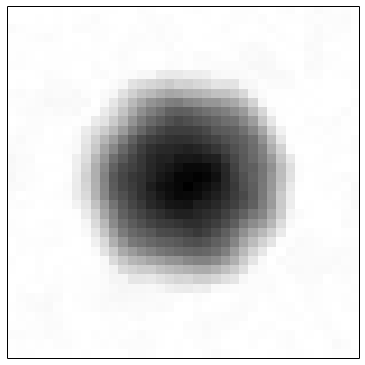

In [315]:
plot = plotting.Plot(fontsize=8, axes_visible=False, save_png=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.plotting_a_map(0, np.abs(superimage)[45:-45,45:-45], cmap='gray_r')
#plot.plotting_a_rectangle(0, 100, 118, 40./(1e9*dx), 2, facecolor='w', edgecolor='w')
#plot.axes[0].text(100+20./(1e9*dx), 116, '40 nm', ha='center', va='bottom', fontsize=12, color='w')
#plot.save('../plots/phasing_recons.png')
plot.show()

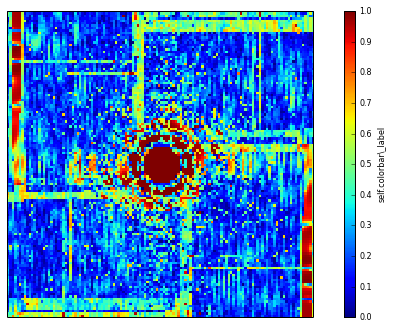

In [316]:
plot = plotting.Plot(fontsize=8, colorbar=True, axes_visible=False, save_png=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.plotting_a_map(0, prtf_2d, mask=None, log=False, vmin=0, vmax=1, bad='0.8', under='w', cmap='jet')

The PRTF drops below 1/e at a resolution of 11.62 nm


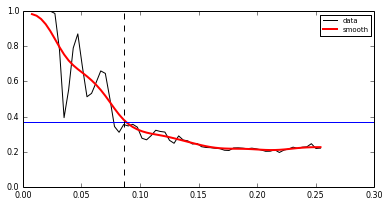

In [317]:
nx, ny = prtf_2d.shape[1], prtf_2d.shape[0]
xx,yy = np.meshgrid(np.arange(nx),np.arange(ny))
mask_radial = np.sqrt((xx-nx/2)**2 + (yy-ny/2)**2) < nx/2
prtf_centers, prtf_radial = spimage.radialMeanImage(prtf_2d, msk=mask_cropped&mask_radial, output_r=True)
prtf_qr = x_to_q(prtf_centers, distance_front)
limit_qr = prtf_qr[np.abs(ndimage.gaussian_filter1d(prtf_radial,2) - (1/np.e)).argmin()]
plot = plotting.Plot(fontsize=8, aspect=.5, legend=True, save_pdf=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.plotting_traces(0, [prtf_qr, prtf_qr], 
                     [prtf_radial, ndimage.gaussian_filter1d(prtf_radial,3)], 
                     ['data', 'smooth'], ylim=[0,1],
                     linestyles=['-','-'], linewidths=[1,2], markers=[None,None],
                     mecs=['k', 'r'], mfcs=['k', 'r'], colors=['k','r'])
plot.axes[0].axhline(1/np.e)
plot.axes[0].axvline(limit_qr, color='k', ls='--')
print "The PRTF drops below 1/e at a resolution of %.2f nm" %(1./limit_qr)